# kNN Evaluation Example

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#When importing libraries that have several packages with corresponding functions
#If you know you will only need to use one specific function from a certain package
#It is better to simply import it directly, as seen below, since it is more efficient and allows for greater simplicity later on
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

## Load Data

In [2]:
#Read in the data from the github repo, you should also have this saved locally...
bank_data = pd.read_csv("https://raw.githubusercontent.com/UVADS/DS-3001/main/07_ML_Eval_Metrics/bank.csv")

In [3]:
#Let's take a look
print(bank_data.dtypes)
bank_data.head()

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
contact      object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
signed up     int64
dtype: object


,age,job,marital,education,default,balance,housing,contact,duration,campaign,pdays,previous,poutcome,signed up
0,43,self-employed,married,tertiary,no,64,no,unknown,230,2,-1,0,unknown,0
1,74,retired,married,primary,no,5539,no,cellular,253,2,181,1,success,0
2,33,management,married,tertiary,no,373,no,cellular,384,1,-1,0,unknown,0
3,37,blue-collar,married,secondary,no,934,no,unknown,258,2,-1,0,unknown,0
4,30,technician,married,tertiary,no,1,no,cellular,69,21,-1,0,unknown,0


## Clean the Data

In [4]:
#Drop any rows that are incomplete (rows that have NA's in them)
bank_data = bank_data.dropna() #dropna drops any rows with any NA value by default

In [5]:
#In this example our target variable is the column 'signed up', lets convert it to a category so we can work with it
bank_data['signed up'] = bank_data['signed up'].astype("category")

In [6]:
bank_data.dtypes #looks good

age             int64
job            object
marital        object
education      object
default        object
balance         int64
housing        object
contact        object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
signed up    category
dtype: object

## kNN data prep

In [7]:
#Before we form our model, we need to prep the data...
#First let's scale the features we will be using for classification
#Remember this essentially just converts the raw values to z-scores, standardizing them
bank_data[["age","duration","balance"]]= StandardScaler().fit_transform(bank_data[["age","duration","balance"]])

In [8]:
#Next we are going to partition the data, but first we need to isolate the independent and dependent variables
X = bank_data[["age","duration","balance"]]  #independent variables
y = bank_data['signed up']                  #dependent variable
#Sometimes you will see only the values be taken using the function .values however this is simply personal preference 
#Since there are several independent variables, I decided to keep the labels in order to distinguish a specific independent variable if needed.

In [9]:
#Now we partition, using our good old friend train_test_split 
#The train_size parameter can be passed a percent or an exact number depending on the circumstance and desired output
#In this case an exact number does not necessarily matter so let's split by percent 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, stratify = y, random_state=21)
#Remember specifying the parameter 'stratify' is essential to perserve class proportions when splitting, reducing sampling error 
#Also set the random_state so our results can be reproducible 

In [10]:
#Now we need to use the function again to create the tuning set
#We want equally sized sets here so let's pass 50% to train_size
X_tune, X_test, y_tune, y_test = train_test_split(X_test,y_test,  train_size = 0.50, stratify = y_test,random_state=49)
#In this example, we are just going to use the train and tune data.

## Model Building 

In [11]:
#Finally, it's time to build our model!
#Here is a function we imported at the beginning of the script,
#In this case it allows us to create a knn model and specify number of neighbors to 10
bank_3NN = KNeighborsClassifier(n_neighbors=10)
#Now let's fit our knn model to the training data
bank_3NN.fit(X_train, y_train)
#note this is simply a model, let's apply it to something and get results!

KNeighborsClassifier(n_neighbors=10)

In [12]:
#This is how well our model does when applied to the tune set
bank_3NN.score(X_tune, y_tune) #This is the probability that our model predicted the correct output based on given inputs, not bad...

0.8876833740831296

## Evaluation Metrics 

In [13]:
#In order to take a look at other metrics, we first need to extract certain information from our model
#Let's retrieve the probabilities calculated from our tune set
bank_prob1 = bank_3NN.predict_proba(X_tune) #This function gives percent probability for both class (0,1)
bank_prob1[:5] #both are important depending on our question, in this example we want the positive class

array([[1. , 0. ],
       [0.4, 0.6],
       [0.9, 0.1],
       [1. , 0. ],
       [1. , 0. ]])

In [14]:
#Now let's retrieve the predictions, based on the tuning set...
bank_pred1 = bank_3NN.predict(X_tune)
bank_pred1[:5] #looks good, notice how the probabilities above correlate with the predictions below

array([0, 1, 0, 0, 0])

In [15]:
#Building a dataframe for simplicity, including everything we extracted and the target
final_model= pd.DataFrame({'neg_prob':bank_prob1[:, 0], 'pred':bank_pred1,'target':y_tune, 'pos_prob':bank_prob1[:, 1]})
#Now everything is in one place!

In [16]:
final_model.head() #Nice work!

,neg_prob,pred,target,pos_prob
29942,1.0,0,0,0.0
23666,0.4,1,1,0.6
8177,0.9,0,0,0.1
25673,1.0,0,0,0.0
32191,1.0,0,0,0.0


In [17]:
#Now let's create a confusion matrix by inputing the predications from our model and the original target
metrics.confusion_matrix(final_model.target,final_model.pred) #looks good, but simplistic...

array([[5678,  105],
       [ 630,  131]])

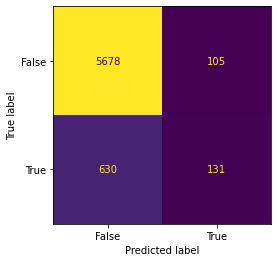

In [18]:
#Let's make it a little more visually appealing so we know what we are looking at 
#This function allows us to include labels which will help us determine number of true positives, fp, tn, and fn
metrics.ConfusionMatrixDisplay.from_predictions(final_model.target,final_model.pred, display_labels = [False, True], colorbar=False)
#Ignore the color, as there is so much variance in this example it really is not telling us anything

In [19]:
#What if we want to adjust the threshold to produce a new set of evaluation metrics
#Let's build a function so we can make the threshold whatever we want, not just the default 50%
def adjust_thres(x,y,z):
  #x=pred_probablities, y=threshold, z=test_outcome
  thres = (np.where(x > y, 1,0))
  #np.where is essentially a condensed if else statement. The first argument is the condition, then the true output, then the false output
  return metrics.ConfusionMatrixDisplay.from_predictions(z,thres, display_labels = [False, True], colorbar=False)


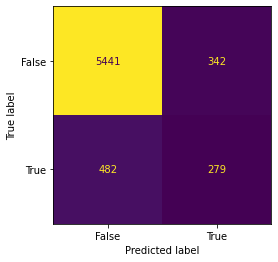

In [20]:
# Give it a try with a threshold of .35
adjust_thres(final_model.pos_prob,.35,final_model.target)
#What's the difference? Try different percents now, what happens?

Text(0.5, 0, 'False Positive Rate')

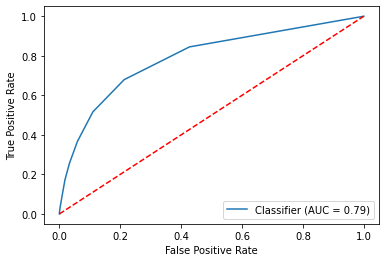

In [21]:
#Now let's use our model to obtain an ROC Curve and the AUC
metrics.RocCurveDisplay.from_predictions(final_model.target, final_model.pos_prob)
#Set labels and midline...
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [22]:
#Let's extract the specific AUC value now
metrics.roc_auc_score(final_model.target, final_model.pos_prob) #Looks good!

0.7887051925951797

In [23]:
#Determine the log loss
metrics.log_loss(final_model.target, final_model.pos_prob)

0.8399416798747916

In [24]:
#Get the F1 Score
metrics.f1_score(final_model.target, final_model.pred)

0.26278836509528586

In [25]:
#Extra metrics
print(metrics.classification_report(final_model.target, final_model.pred)) #Nice Work!

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      5783
           1       0.56      0.17      0.26       761

    accuracy                           0.89      6544
   macro avg       0.73      0.58      0.60      6544
weighted avg       0.86      0.89      0.86      6544

